# Metrik Evaluation for Heatmap-Boundarbox overlay
## 1.0 Preprocessing
First we need the dataframe BBox_List_2017.csv, which contains Baounarybox data from all Categories. So we need to filter it for Pneumothorax and Cardiomegaly. So Pneumothorax will be Label 0

In [2]:
import pandas as pd
import torch
import os
from cnn2 import AlexNet
from scipy import ndimage
from PIL import Image
import numpy as np
import seaborn as sns



import warnings
warnings.filterwarnings("ignore")

In [3]:
methode = "gradient_shap"

data_path = "../../../../data/"
hm_path = data_path + f"xai/nih/{methode}/heat_map/"
models_path = data_path + "xai/nih/models/"

colors = ["#FF00FF", "#76BA1B"]
labels = ["Cardiomaly", "Pneomothorax", ]

In [4]:
# Resolution of Heatmaps
m1_list = os.listdir(hm_path+"model1")
im = Image.open(hm_path+f"model1/{m1_list[5]}")
im_size = im.size
print(im_size)

# boundarybox is at size 1024 so bbox point have to be adjusted at
im_ratio = im_size[0]/1024

(338, 338)


In [5]:
padding = 2

<AxesSubplot:>

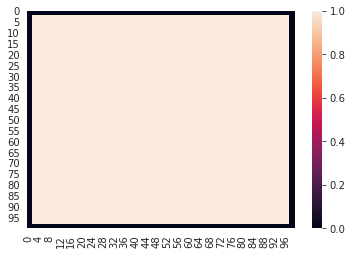

In [6]:
def npPadding(a):
    a[0:padding] = 0
    a[:,0:padding] = 0
    a[padding*-1:-1] = 0
    a[-1] = 0
    a[:,padding*-1:-1] = 0
    a[:,-1] = 0
    return a


sns.heatmap(npPadding(np.ones((100,100))))

In [7]:
models_folder = os.listdir(models_path)
model_list = []
for mo in models_folder:
    print(mo)
    model = AlexNet().to("cpu")
    model.load_state_dict(torch.load(models_path + f"{mo}", map_location=torch.device('cpu')))
    model = model.eval()
    model_list.append(model)
    del model

testAcc0_90106545.pth
vL0_00016008.pth
vL0_00768024.pth
vL0_00505538.pth
ztestAcc0_58333333.pth


In [8]:
#read dataframe
df = pd.read_csv('/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/BBox_List_2017.csv')

In [9]:
## filter dateframe to only Pneumothorax or Cardiomaly
df_pneumo = df[df['Finding Label']=='Pneumothorax']

In [10]:
df_cardio = df[df['Finding Label']=='Cardiomegaly']

In [11]:
df =  pd.concat([df_pneumo, df_cardio])
df_lean = df[["Image Index", "Finding Label"]]
df.head(5)

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8
867,00019892_003.png,Pneumothorax,570.595556,119.789045,254.862222,98.986667,NaN,NaN,NaN
868,00030162_026.png,Pneumothorax,539.875556,268.837934,94.435556,73.955556,NaN,NaN,NaN
869,00013659_019.png,Pneumothorax,291.840000,84.517934,106.951111,50.062222,NaN,NaN,NaN
870,00026586_009.png,Pneumothorax,196.266667,186.917934,170.666667,129.706667,NaN,NaN,NaN
871,00020000_000.png,Pneumothorax,270.222222,132.304601,88.746667,28.444444,NaN,NaN,NaN


In [12]:
#list for sample pictures
df_cardio.head(5)["Image Index"].tolist()

['00005066_030.png',
 '00009608_024.png',
 '00000661_000.png',
 '00019018_007.png',
 '00000211_041.png']

In [13]:
df_pneumo.head(5)["Image Index"].tolist()

['00019892_003.png',
 '00030162_026.png',
 '00013659_019.png',
 '00026586_009.png',
 '00020000_000.png']

Now we need to make a label encoding.

In [14]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['Finding Label']= label_encoder.fit_transform(df['Finding Label'])
#df['Finding Label'].unique()

# save to csv
#df.to_csv('/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/BBox_List_2017_pneumo_cardio.csv', index=False)


In [15]:
df.head(5)

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8
867,00019892_003.png,1,570.595556,119.789045,254.862222,98.986667,NaN,NaN,NaN
868,00030162_026.png,1,539.875556,268.837934,94.435556,73.955556,NaN,NaN,NaN
869,00013659_019.png,1,291.840000,84.517934,106.951111,50.062222,NaN,NaN,NaN
870,00026586_009.png,1,196.266667,186.917934,170.666667,129.706667,NaN,NaN,NaN
871,00020000_000.png,1,270.222222,132.304601,88.746667,28.444444,NaN,NaN,NaN


### 1.1 Get right folderstring

The bbox dataset comes with pathes, witch misses the folder name. So we need to do something to handle this.
First we need to import the complete dataset, with all categories, just without the multiple categories.

In [16]:
df_chest = pd.read_csv("/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/allLabels.csv")
print(f"lengt of df : {df_chest.shape[0]}")

lengt of df : 91323


Second, we need to iterate over all files from the folder Chest and look witch pathes are equal to the bboy dataframe.
Than store it in a list of dataframes, and concatenate all together.

In [17]:
import os

df_list = []
for i in range(1,13):
    dire = "/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/images_00"
    if i>=10:
        dire = dire[:-1]
    path = dire+str(i)+"/images"
    liste = os.listdir(path)
    df_cest_new = df[df["Image Index"].isin(liste)].copy()
    df_cest_new["path"] = path[69:]
    df_list.append(df_cest_new)


df1 = pd.concat(df_list)
df1["path"] = df1["path"] + "/" + df1["Image Index"]
df2 = df1.copy()
df1_lean = df2[["path","Finding Label"]]
df1_lean

,path,Finding Label
918,images_001/images/00000732_005.png,1
921,images_001/images/00001248_038.png,1
163,images_001/images/00000661_000.png,0
165,images_001/images/00000211_041.png,0
182,images_001/images/00000377_004.png,0
...,...,...
248,images_012/images/00029391_000.png,0
281,images_012/images/00030279_000.png,0
290,images_012/images/00029647_002.png,0
296,images_012/images/00028607_000.png,0


If everythong worked out, the df1 should be the same as df.

In [18]:
print(f"df1 = {df.shape[0]} \ndf2 = {df1.shape[0]} ")

df1 = 244 
df2 = 243 


In [19]:
df1["area"] = df1["w"]*df1["h"]

In [20]:
#df1.to_csv('/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/BBox_List_2017_pneumo_cardio_lean.csv', index=False)

## 2.0 Boundarybox Numpy Array

So we have the values x,y,w,h . (x,y) representing the corner, w the with and h the height.
The following code makes a dictionary, named with the imagename, and filled with a numpy array(greyscale)

In [21]:
import numpy as np
result_bb_l = []
result_bb_center_l = []
result_bb_frame = []
for i in range(len(df1)):
    t_in = np.zeros(im_size)
    t_out = np.ones(im_size)
    x = int(df1["x"].values[i]*im_ratio)
    y = int(df1["y"].values[i]*im_ratio)
    w = int(df1["w"].values[i]*im_ratio)
    h = int(df1["h"].values[i]*im_ratio)
    t_in[y:y+h,x:x+w]=np.ones((h,w))
    t_out[y:y+h,x:x+w]=np.zeros((h,w))
    #name = df1['path'].values[i][18:]
    result_bb_l.append(t_in)
    result_bb_center_l.append([x+w/2,y+h/2])
    #t_out2 = t_out.copy()
    #t_out2[y+5:y+5+h-10,x+5:x+5+w-10]=np.ones((h-10,w-10))
    #result_bb_frame.append(out2)
result_bb_center = df1[["path"]]
result_bb_center["path"] = result_bb_center["path"].str[18:]
result_bb_center["center"] = result_bb_center_l

result_bb = df1[["path"]]
result_bb["path"] = result_bb["path"].str[18:]
result_bb["img"] = result_bb_l


### 2.1 Making a Mask

The boundarybox is a numpyarray with all zeros, just inside the bounding box there are ones.
The heatmap is a numpyarray with values from 0 to 255.
We count every value who is inside the boundarybox.
So we just multiply the two matrices by its inner product.

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sample_path = result_bb["path"].sample(1).item()
sample_mask = result_bb[result_bb["path"]==sample_path]["img"].item()

shape of result =  (338, 338)


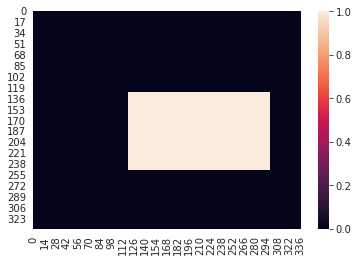

In [23]:
print("shape of result = ", sample_mask.shape)
ax = sns.heatmap(sample_mask)
plt.show()

<AxesSubplot:>

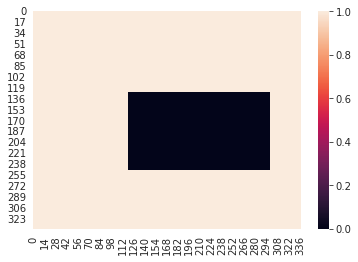

In [24]:
sns.heatmap(1-sample_mask)

In [25]:
#sns.heatmap(result_bb_frame['model1'][0])

## 3.0 Extracting heatmaps numpys
The Heatmaps were created with captum and stored in the folder /2dheatmapsOcculusion.
So all we need to do is



In [26]:
from numpy import asarray
from PIL import Image,ImageOps

l = os.listdir(f"../../../../data/xai/nih/{methode}/heat_map/model1")
l.pop()
result_hm_dict = {"path":l}
for m in range(1,len(model_list)+1):
    liste = os.listdir(f"../../../../data/xai/nih/{methode}/heat_map/model{m}")
    liste.pop()
    result_hm = []
    for i in liste:
        if i.endswith(".csv"):
            break
        image = Image.open(f'../../../../data/xai/nih/{methode}/heat_map/model{m}/{i}')
        image = ImageOps.grayscale(image)
        image = ImageOps.invert(image)
        image = image.resize(im_size)
        # convert image to numpy array
        data = asarray(image)
        # padding
        data = npPadding(data)
        #data = data[5:-5,5:-5]
        result_hm.append(data)
    result_hm_dict[f"model{m}"]= result_hm

In [27]:
result_hm = pd.DataFrame(result_hm_dict)

shape of Image =  (338, 338)


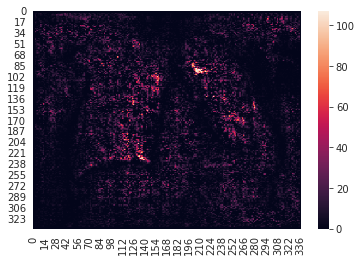

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
print("shape of Image = ",result_hm_dict["model1"][0].shape)
ax = sns.heatmap(result_hm_dict["model1"][0])
plt.show()

In [29]:
results = result_hm.merge(result_bb,on="path")
results = result_bb_center.merge(results,on="path")
results

,path,center,model1,model2,model3,model4,model5,img
0,00001248_038.png,"[228.5, 58.5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,00000661_000.png,"[188.5, 214.5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00000211_041.png,"[157.5, 208.0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,00000377_004.png,"[210.5, 198.5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,00000211_019.png,"[194.5, 206.0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
236,00029391_000.png,"[184.0, 184.0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
237,00030279_000.png,"[185.0, 213.0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
238,00029647_002.png,"[191.5, 197.5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
239,00028607_000.png,"[215.0, 172.0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [30]:
final_result_outside2 = results[["path"]]
final_result_outside2[f"model1"] = results[f"model1"] * results["img"]

In [31]:
final_result_outside2[f"model2"] = results[f"model2"] * results["img"]

In [32]:
final_result_outside2[f"model3"] = results[f"model3"] * results["img"]

In [33]:
final_result_outside2[f"model4"] = results[f"model4"] * results["img"]

In [34]:
final_result_outside2[f"model5"] = results[f"model5"] * results["img"]

In [35]:
final_result_outside2

,path,model1,model2,model3,model4,model5
0,00001248_038.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,00000661_000.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00000211_041.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,00000377_004.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,00000211_019.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...
236,00029391_000.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
237,00030279_000.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
238,00029647_002.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
239,00028607_000.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [36]:
sample_out1 = final_result_outside2[final_result_outside2["path"]==sample_path]["model1"].item()

<AxesSubplot:>

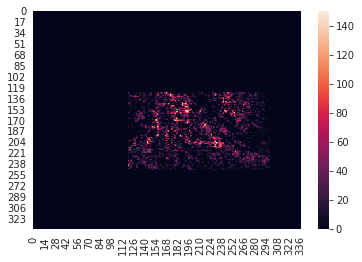

In [37]:
sns.heatmap(sample_out1)

In [38]:
final_result_inside = results[["path"]]
final_result_inside[f"model1"] = results[f"model1"] * (1 - results["img"])

In [39]:
final_result_inside[f"model2"] = results[f"model2"] * (1 - results["img"])

In [40]:
final_result_inside[f"model3"] = results[f"model3"] * (1 - results["img"])

In [41]:
final_result_inside[f"model4"] = results[f"model4"] * (1 - results["img"])

In [42]:
final_result_inside[f"model5"] = results[f"model5"] * (1 - results["img"])

In [43]:
sample_in1 = final_result_inside[final_result_inside["path"]==sample_path]["model1"].item()

<AxesSubplot:>

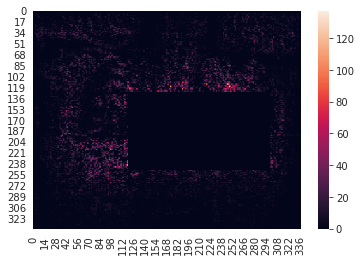

In [44]:
sns.heatmap(sample_in1)

## 4.0 Calculating the metrics
The metrics I will use is :
1. Sum of values inside the box devided through all the values the box
2. Distance between middle of bbox and the weighted center of the heatmap



In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_dist(df,c,h):
    df = df[["model1","model2","model3","model4","model5"]]
    mx = df.max().max()
    mn = df.min().min()
    fig = plt.figure(figsize=(20,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1,len(model_list)+1):
        ax = fig.add_subplot(1, len(model_list)+1, i)
        sns.distplot(df[f"model{i}"],ax=ax,bins=15,color=c)
        ax.set(ylim=(0, h),xlim=(mn,mx))
    plt.show()

In [46]:
def plot_distDict(df,c,h,mx):
    fig = plt.figure(figsize=(20,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1,len(model_list)+1):
        ax = fig.add_subplot(1, len(model_list)+1, i)
        sns.distplot(df[f"model{i}"],ax=ax,bins=15,color=c)
        ax.set(ylim=(0, h),xlim=(0,mx))
    plt.show()

In [47]:
def violinPlot1(df, mx):
    fig, ax = plt.subplots()
    ax.set(ylim=(0, mx))
    sns.violinplot(data=df)


def violinPlot(df, mx):
    maxsize = max([len(a) for a in df.values()])
    data_pad = {k: np.pad(v, pad_width=(0, maxsize - len(v)), mode='constant', constant_values=np.nan) for k, v in
                df.items()}
    df_p = pd.DataFrame(data_pad)
    fig, ax = plt.subplots()
    ax.set(ylim=(0, mx))
    sns.violinplot(data=df_p)

### 4.2 Metrik 1

In [48]:
# metrik 1
def metrik1(df_o,df_i,m):
    metrik1_l = []
    for i in range(len(df_o)):
        metrik1_l.append(np.sum(df_o[f"model{m}"][i]) / (np.sum(np.abs(df_o[f"model{m}"][i]-1))+ np.sum(df_i[f"model{m}"][i])) * 100)
    return metrik1_l

In [49]:
def runMerik1(df_o,df_i,modus,mmodus=None):
    for m in range(1,len(model_list)+1):
        dftt = pd.read_csv(data_path+f"xai/nih/{methode}/heat_map/model{m}/results.csv")
        dftt = dftt[["path","Finding Label","predicted"]]
        dftt["path"] = dftt["path"].str[18:]
        if modus == "n" or modus == "l":
            if modus == "l":
                dftt = dftt[dftt["Finding Label"]==int(mmodus)]
        #filtered by correct
        elif modus == "c" :
            if mmodus == 1:
                dftt =  dftt[dftt["Finding Label"]!= dftt["predicted"]]
            elif mmodus == 0:
                    dftt =  dftt[dftt["Finding Label"]== dftt["predicted"]]

        dftt_o = df_o.merge(dftt,on="path")
        dftt_i = df_i.merge(dftt,on="path")
        if m == 1:
            df_results = {}
            df_results[f"model{m}"] = metrik1(dftt_o,dftt_i,m)
        else:
            df_results[f"model{m}"] = metrik1(dftt_o,dftt_i,m)
    return df_results

In [50]:
df_m1_r  = pd.DataFrame(runMerik1(final_result_outside2,final_result_inside,"n"))
df_m1_r0 = pd.DataFrame(runMerik1(final_result_outside2,final_result_inside,"l",0))
df_m1_r1 = pd.DataFrame(runMerik1(final_result_outside2,final_result_inside,"l",1))
m1_rc0 = runMerik1(final_result_outside2,final_result_inside,"c",0)
m1_rc1 = runMerik1(final_result_outside2,final_result_inside,"c",1)

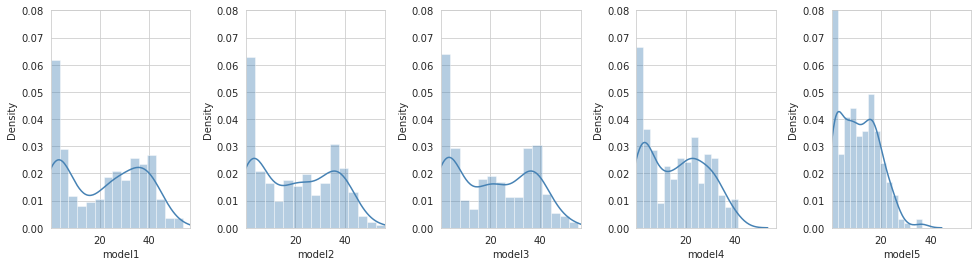

In [51]:
plot_dist(df_m1_r,"steelblue",.08)

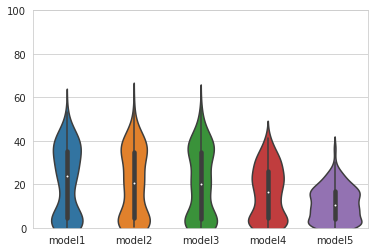

In [52]:
violinPlot1(df_m1_r,100)

### 4.3 Metrik 2

In [53]:
# metrik 2
def metrik2(df,m):
    metrik2_l = []
    for i in range(len(df)):
        center_hm = ndimage.measurements.center_of_mass(df[f"model{m}"][i])
        center_bb = df["center"][i]
        metrik2_l.append(((center_hm[0]-center_bb[0])**2+(center_hm[1]-center_bb[1])**2)**(1/2))
    return metrik2_l

In [54]:
def runMetrik2(df,modus,mmodus=None):
    for m in range(1,len(model_list)+1):
        dftt = pd.read_csv(data_path+f"xai/nih/{methode}/heat_map/model{m}/results.csv")
        dftt = dftt[["path","Finding Label","predicted"]]
        dftt["path"] = dftt["path"].str[18:]
        if modus == "n" or modus == "l":
            if modus == "l":
                dftt = dftt[dftt["Finding Label"]==int(mmodus)]
        #filtered by correct
        elif modus == "c" :
            if mmodus == 1:
                dftt =  dftt[dftt["Finding Label"]!= dftt["predicted"]]
            elif mmodus == 0:
                    dftt =  dftt[dftt["Finding Label"]== dftt["predicted"]]

        dfttf = dftt.merge(df,on="path")
        if m == 1:
            df_results = {}
        df_results[f"model{m}"] = metrik2(dfttf,m)
    return df_results

In [55]:
df_m2_r = pd.DataFrame(runMetrik2(results,"n"))
df_m2_r0 = pd.DataFrame(runMetrik2(results,"l",0))
df_m2_r1 = pd.DataFrame(runMetrik2(results,"l",1))
m2_rc0 = runMetrik2(results,"c",0)
m2_rc1 = runMetrik2(results,"c",1)

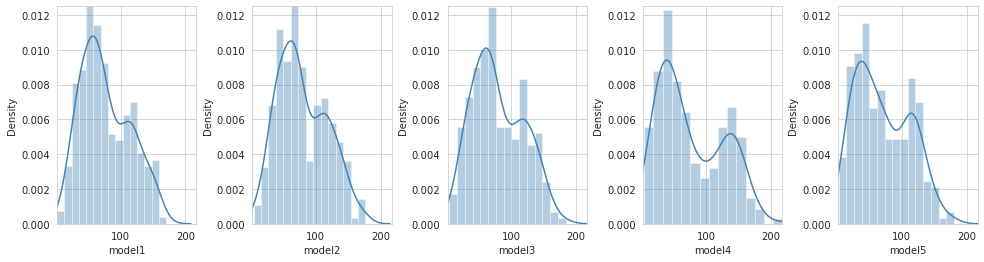

In [56]:
plot_dist(df_m2_r,"steelblue",0.0125)

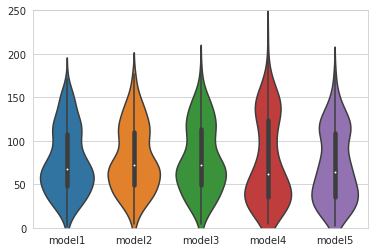

In [57]:
violinPlot1(df_m2_r,250)

### 4.4 Analyse der Labels
#### 4.4.1 Cardiomegaly
##### 4.4.1.1 Metrik 1

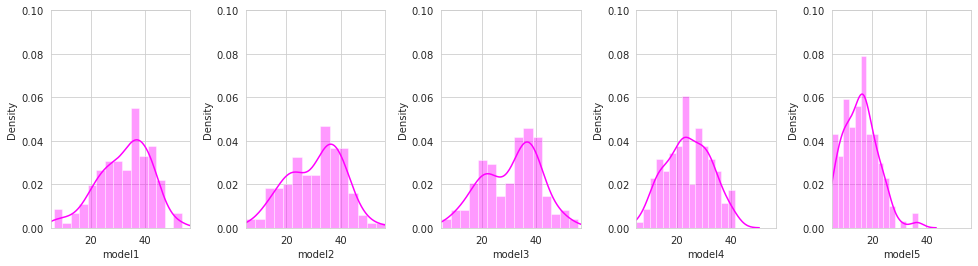

In [58]:
plot_dist(df_m1_r0,colors[0],.10)

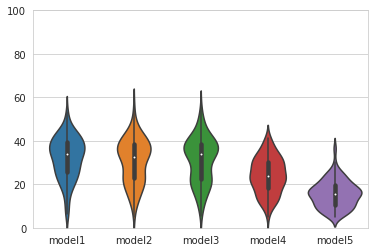

In [59]:
violinPlot1(df_m1_r0,100)

##### 4.4.1.2  Metrik 2

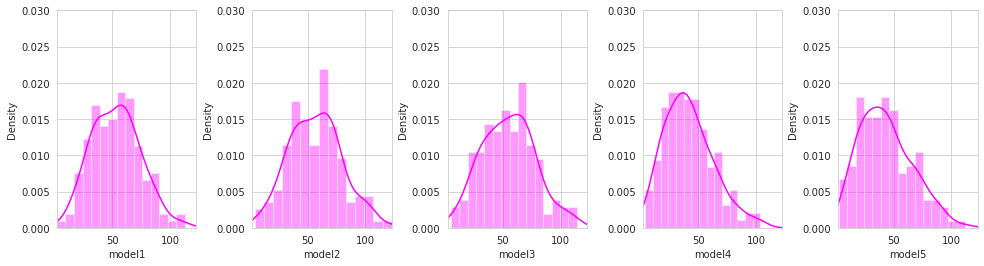

In [60]:
plot_dist(df_m2_r0,colors[0],.03)

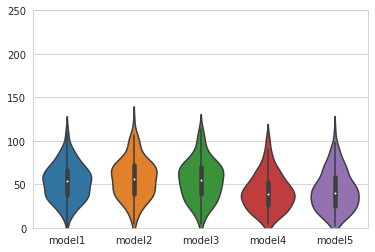

In [61]:
violinPlot1(df_m2_r0,250)

#### 4.4.2  Pneumothorax
###### 4.4.2.1 Metrik 1

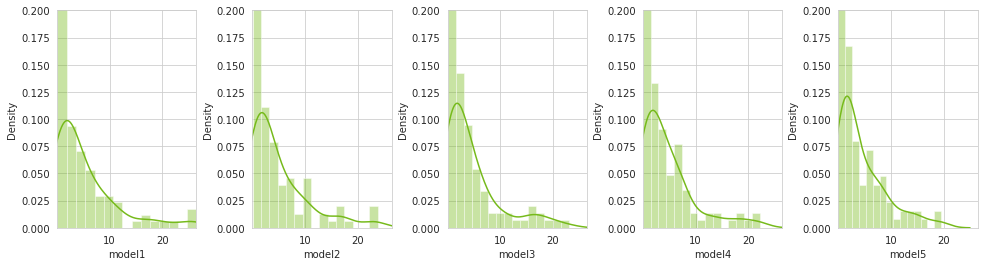

In [62]:
plot_dist(df_m1_r1, colors[1], .2)

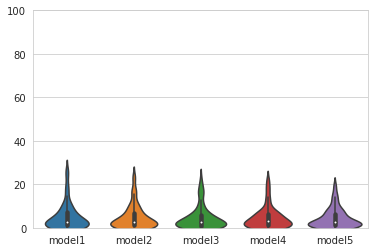

In [63]:
violinPlot1(df_m1_r1,100)

##### 4.4.2.2 Metrik 2

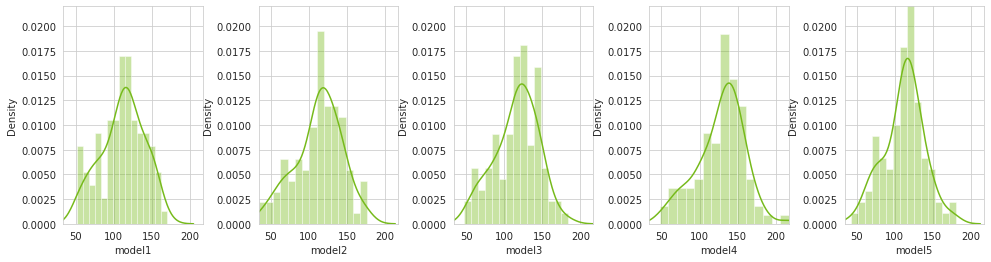

In [64]:
plot_dist(df_m2_r1, colors[1], .022)

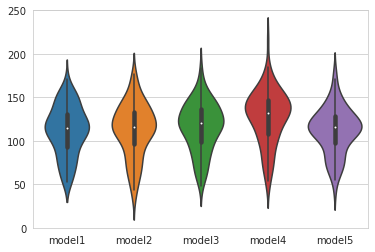

In [65]:
violinPlot1(df_m2_r1,250)

#### 4.4.3 Unterscheidung zwischen richtigen und falsch Prediction Modellen
##### 4.4.3.1 Richtig
###### 4.4.3.1.1 Metrik 1

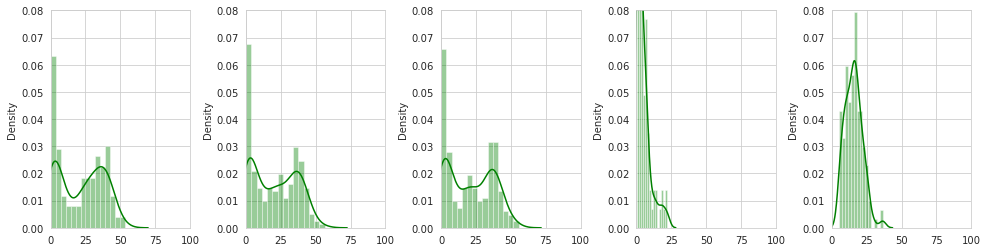

In [66]:
plot_distDict(m1_rc0,"green",0.08,100)

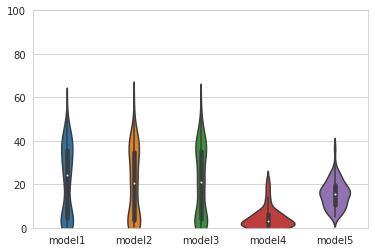

In [67]:
violinPlot(m1_rc0,100)

###### 4.4.3.1.2 Metrik 2

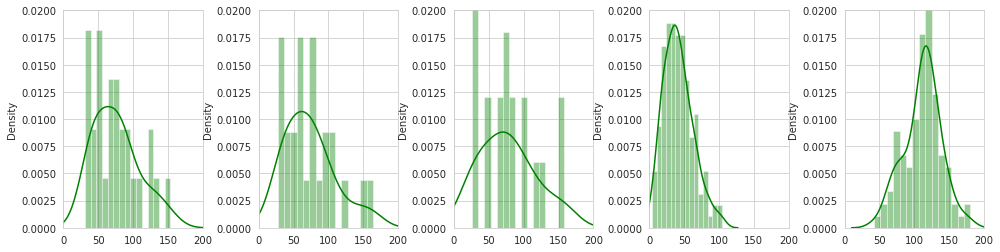

In [68]:
plot_distDict(m2_rc1, "green",.02,200)

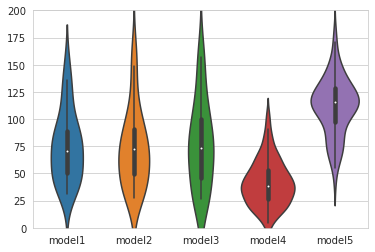

In [69]:
violinPlot(m2_rc1,200)

##### 6.3.1.2 Falsch
###### 6.3.1.2.1 Entropie

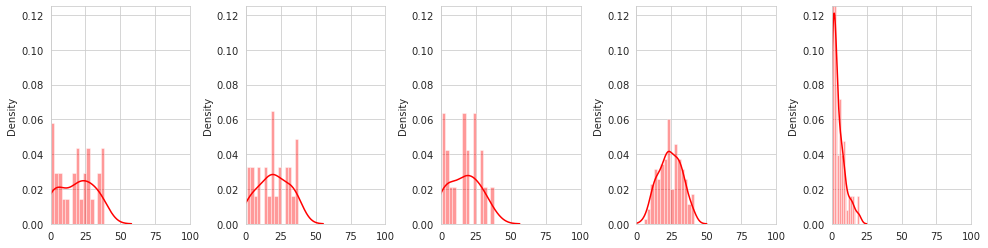

In [70]:
plot_distDict(m1_rc1, "red", .125,100)

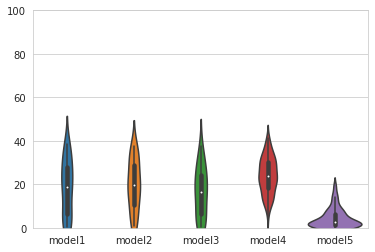

In [71]:
violinPlot(m1_rc1,100)

###### 6.3.1.2.2 D of COM

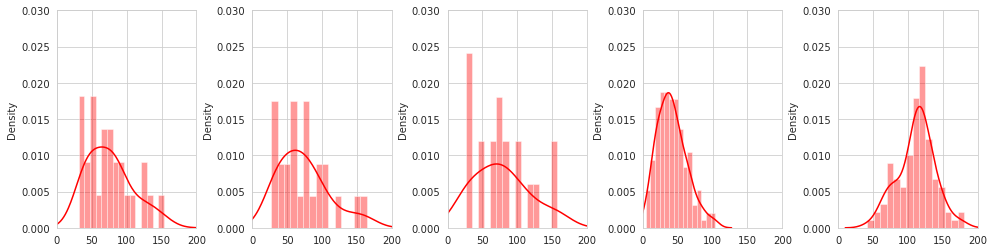

In [72]:
plot_distDict(m2_rc1, "red", .03,200)

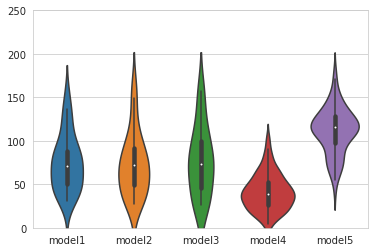

In [73]:
violinPlot(m2_rc1,250)

## 5.0 Sample pictures for classes with bbox


In [74]:
#df2_lean_0 = df2_lean[df2_lean["Finding Label"]==0].sample(5)
#for i in df2_lean_0["path"].tolist():
#    img = Image.open(f"../../../data/Chest/{i}")
#    ar = np.asarray(img)
#    ar = ar * result_bb_frame[i[18:]]
#    p1 = sns.heatmap(ar)
#    fig1 = p1.get_figure()
#    fig1.savefig(f"../../../data/xai/nih/samples/pneumo/bbox{i[18:]}", bbox_inches="tight",pad_inches=0)
#    img2 = img.save(f"../../../data/xai/nih/samples/pneumo/{i[18:]}")

In [75]:
#img = Image.open(f"../../../data/Chest/images_001/images/00000661_000.png")
#ar = np.asarray(img)
#ar = ar *result_bb_frame["00000661_000.png"]
#sns.heatmap(ar)

## 6.0 Save Results

In [76]:
#os.makedirs("results_bb", exist_ok=False)
#os.makedirs(f"results_bb/{methode}", exist_ok=False)
import json

df_m1_r.to_csv(f"results_bb/{methode}/allresults.csv")
df_m2_r.to_csv(f"results_bb/{methode}/allresults_m2.csv")

#l0
df_m1_r0.to_csv(f"results_bb/{methode}/l0results.csv")
df_m2_r0.to_csv(f"results_bb/{methode}/l0results_m2.csv")

#l1
df_m1_r1.to_csv(f"results_bb/{methode}/l1results.csv")
df_m1_r1.to_csv(f"results_bb/{methode}/l1results_m2.csv")

# c0
with open(f"results_bb/{methode}/c0results.json", 'w') as fp:
    json.dump(m1_rc0, fp)
with open(f'results_bb/{methode}/c0results2.json', 'w') as fp:
    json.dump(m2_rc0, fp)

#c1
with open(f'results_bb/{methode}/c1results.json', 'w') as fp:
    json.dump(m1_rc1, fp)
with open(f'results_bb/{methode}/c1results2.json', 'w') as fp:
    json.dump(m2_rc1, fp)